# [E-16] Session-Based Recommendation 
## 다음에 볼 영화 예측하기
### 학습 목표
* Session-Based Recommendation 에 대한 이해하기

### 목차
#### 1. 들어가며
  1-1. Session-Based Recommendation      
  1-2. Movielens 데이터       

#### 2. 프로젝트 진행
  2-1. 데이터 확인 및 전처리      
  2-2. 미니 배치의 구성      
  2-3. 모델 구성      
  2-4. 모델 학습       
  2-5. 모델 훈련 준비        
  2-6. 모델 추가 학습 및 테스트       

#### 3. 회고
  3-1. 프로젝트를 진행하면서 알아낸 점, 혹은 아직 모호한 점       
  3-2. 에러       
  3-3. 루브릭 평가 지표를 맞추기 위해 시도한 것들       
  3-4. 참고사이트        







### 루브릭 평가 기준
|평가문항|상세기준|
|:---|:---|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|   
<br/>

----


## 1. 들어가며
### 1-1. Session-Based Recommendation
* 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천
* Session이란 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버에 저장됨

### 1-2. Movielens 데이터
* rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있음
* 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
* 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
* 별점을 시청횟수로 해석해서 생각하겠습니다.
* 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.

## 2. 프로젝트 진행
### 2-1. 데이터 확인 및 전처리

#### 라이브러리 버전 확인 및 import

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import tensorflow

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)
print(tensorflow.__version__)


1.3.3
2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/Exploration/E_16/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


#### UTC time 형태를 datetime 형태로 바꾸기
* UTC time 형태로 되어있는 시간을 datetime 형태로 바꾸어 살펴보기

In [3]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


#### 유저 수(세션 수)와 아이템 수 확인

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

#### Session Length: 클릭 데이터 확인
**Session_length**
* ```session_length``` : 같은 ```UserId```를 공유하는 데이터 row의 개수를 의미
* ```UserId``` : 브라우저에서 웹서버로 접속할 때 항상 포함되는 정보이자 유저 구분자. 즉 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취했는지 (몇 개의 상품정보를 클릭했는지) 를 의미

In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

#### 각 세션의 길이에 대한 중앙값과 평균
* 보통 96~165 사이

In [6]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

#### 각 세션의 최소 길이와 최대 길이

In [7]:
session_length.min(), session_length.max()

(20, 2314)

#### 99.9%의 세션의 길이의 값

In [8]:
session_length.quantile(0.999)

1343.181000000005

#### 최대 길이 세션 확인하기
* 99%의 세션은 길이가 1343 이하인데 최대 길이는 2314
* 길이가 2314인 데이터 확인하기

In [9]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


#### 세션 길이 기준 하위 99.9%까지의 분포 누적합 시각화

In [10]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

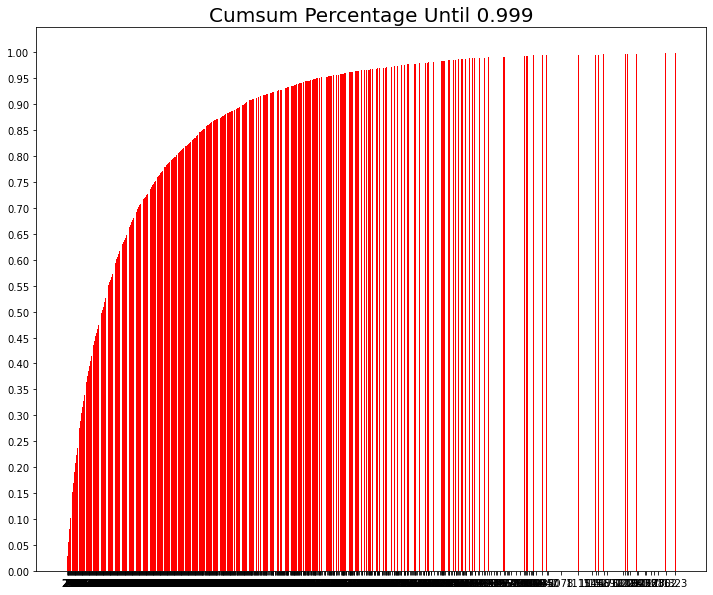

In [11]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### 데이터 시간 정보 확인

In [12]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


* 총 2년 10개월 정도의 데이터가 있음
* 얼마의 데이터를 사용할 것인지 결정해야함 : 1년 데이터 사용?

In [13]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

#### Timestamp 객체의 사칙연산 
* 날짜끼리의 차이를 구하고 싶을 때에는 datetime 라이브러리의 timedelta 객체 사요해야함

In [14]:
# year_ago = latest - dt.timedelta(365)     # 최종 날짜로부터 1년 이전 날짜를 구한다.  
# data = data[data['Time'] > year_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

#### Data Cleansing
* 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거
* 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있음. 그 데이터도 제거. 

#### Data Cleansing
* 연습에서는 길이가 1인 세션의 데이터를 제거했음
* 여기서는 제거할 필요가 있을지 고민해야함 ______

In [15]:
# # short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# # 이를 위해 반복문을 통해 지속적으로 제거 합니다.
# def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
#     while True:
#         before_len = len(data)
#         data = cleanse_short_session(data, shortest)
#         data = cleanse_unpopular_item(data, least_click)
#         after_len = len(data)
#         if before_len == after_len:
#             break
#     return data


# def cleanse_short_session(data: pd.DataFrame, shortest):
#     session_len = data.groupby('UserId').size()
#     session_use = session_len[session_len >= shortest].index
#     data = data[data['UserId'].isin(session_use)]
#     return data


# def cleanse_unpopular_item(data: pd.DataFrame, least_click):
#     item_popular = data.groupby('ItemId').size()
#     item_use = item_popular[item_popular >= least_click].index
#     data = data[data['ItemId'].isin(item_use)]
#     return data

In [16]:
# data = cleanse_recursive(data, shortest=2, least_click=5)
# data

### 2-2. 미니 배치의 구성
* Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성
* 데이터 준비 및 전처리 과정에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수 있음

#### Train / Valid / Test Split
* Valid Set & Test Set 만들기

In [17]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [18]:
tr, test = split_by_date(data, 180)
tr, val = split_by_date(tr, 180)

In [19]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [20]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 811151
	 Sessions: 5549
	 Items: 3671
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-04 22:46:11

* valid Set Stats Info
	 Events: 49590
	 Sessions: 152
	 Items: 3241
	 First Time : 2000-05-01 20:45:43
	 Last Time : 2002-09-01 00:14:13

* test Set Stats Info
	 Events: 139428
	 Sessions: 339
	 Items: 3379
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [21]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [22]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 2-3. 모델 구성
#### Session Dataset

In [23]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [24]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [25]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 810687, 810810, 811151], dtype=int32)

In [26]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5546, 5547, 5548])

### Session Data Loader

In [27]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [28]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [29]:
iter_ex = iter(tr_data_loader)

In [30]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### 2-4. 모델 학습
* 다양한 하이퍼파라미터 변경하며 검증하기
* Recall, MRR 등의 개념들도 함께 관리하기

#### Evaluation Metric

In [31]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture
#### 라이브러리 import

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [33]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [54]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [55]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(128, 1, 3671)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    558450    
_________________________________________________________________
dropout_5 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (128, 3671)               187221    
Total params: 745,671
Trainable params: 745,671
Non-trainable params: 0
_________________________________________________________________


### 2-5. 모델 훈련 준비

In [56]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

### 2-6. 모델 추가 학습 및 테스트
* 미리 구성한 테스트셋 바탕으로 Recall, MRR 확인하기

In [57]:
train_model(model, args)

# # 학습된 모델을 불러옵니다.
# model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  26%|██▌       | 101/386 [00:52<02:28,  1.92it/s]


	 - Recall@20 epoch 1: 0.221689
	 - MRR@20    epoch 1: 0.057551



Evaluation:  26%|██▌       | 101/386 [00:50<02:21,  2.01it/s]


	 - Recall@20 epoch 2: 0.280709
	 - MRR@20    epoch 2: 0.080475



Evaluation:  26%|██▌       | 101/386 [00:48<02:18,  2.06it/s]


	 - Recall@20 epoch 3: 0.308942
	 - MRR@20    epoch 3: 0.092390



Evaluation:  26%|██▌       | 101/386 [00:48<02:17,  2.08it/s]


	 - Recall@20 epoch 4: 0.321550
	 - MRR@20    epoch 4: 0.097476



Evaluation:  26%|██▌       | 101/386 [00:48<02:16,  2.09it/s]


	 - Recall@20 epoch 5: 0.330136
	 - MRR@20    epoch 5: 0.102227



Evaluation:  26%|██▌       | 101/386 [00:48<02:15,  2.10it/s]


	 - Recall@20 epoch 6: 0.336170
	 - MRR@20    epoch 6: 0.104513



Evaluation:  26%|██▌       | 101/386 [00:48<02:16,  2.09it/s]


	 - Recall@20 epoch 7: 0.338800
	 - MRR@20    epoch 7: 0.106131



Evaluation:  26%|██▌       | 101/386 [00:47<02:15,  2.11it/s]


	 - Recall@20 epoch 8: 0.339650
	 - MRR@20    epoch 8: 0.108693



Evaluation:  26%|██▌       | 101/386 [00:47<02:15,  2.11it/s]


	 - Recall@20 epoch 9: 0.340888
	 - MRR@20    epoch 9: 0.110427



Evaluation:  26%|██▌       | 101/386 [00:47<02:14,  2.12it/s]

	 - Recall@20 epoch 10: 0.341584
	 - MRR@20    epoch 10: 0.110589



#### 두번째 시도

In [58]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(64, 1, 3671)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      558450    
_________________________________________________________________
dropout_6 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_6 (Dense)              (64, 3671)                187221    
Total params: 745,671
Trainable params: 745,671
Non-trainable params: 0
_________________________________________________________________


In [59]:
train_model(model, args)

Evaluation:  72%|███████▏  | 553/772 [02:35<01:01,  3.55it/s]


	 - Recall@20 epoch 1: 0.209906
	 - MRR@20    epoch 1: 0.053512



Evaluation:  72%|███████▏  | 553/772 [02:30<00:59,  3.68it/s]


	 - Recall@20 epoch 2: 0.253447
	 - MRR@20    epoch 2: 0.071253



Evaluation:  72%|███████▏  | 553/772 [02:29<00:59,  3.71it/s]


	 - Recall@20 epoch 3: 0.271050
	 - MRR@20    epoch 3: 0.078056



Evaluation:  72%|███████▏  | 553/772 [02:27<00:58,  3.75it/s]


	 - Recall@20 epoch 4: 0.279979
	 - MRR@20    epoch 4: 0.081677



Evaluation:  72%|███████▏  | 553/772 [02:26<00:58,  3.77it/s]


	 - Recall@20 epoch 5: 0.284075
	 - MRR@20    epoch 5: 0.084271



Evaluation:  72%|███████▏  | 553/772 [02:26<00:58,  3.76it/s]


	 - Recall@20 epoch 6: 0.285234
	 - MRR@20    epoch 6: 0.086039



Evaluation:  72%|███████▏  | 553/772 [02:28<00:58,  3.73it/s]


	 - Recall@20 epoch 7: 0.288003
	 - MRR@20    epoch 7: 0.086788



Evaluation:  72%|███████▏  | 553/772 [02:28<00:59,  3.71it/s]


	 - Recall@20 epoch 8: 0.288568
	 - MRR@20    epoch 8: 0.087339



Evaluation:  72%|███████▏  | 553/772 [02:28<00:58,  3.72it/s]


	 - Recall@20 epoch 9: 0.290009
	 - MRR@20    epoch 9: 0.087916



Evaluation:  72%|███████▏  | 553/772 [02:27<00:58,  3.74it/s]

	 - Recall@20 epoch 10: 0.288907
	 - MRR@20    epoch 10: 0.088535



#### 세번째 시도

In [62]:
args = Args(tr, val, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(32, 1, 3671)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      558450    
_________________________________________________________________
dropout_8 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_8 (Dense)              (32, 3671)                187221    
Total params: 745,671
Trainable params: 745,671
Non-trainable params: 0
_________________________________________________________________


In [63]:
train_model(model, args)

Evaluation:  87%|████████▋ | 1347/1544 [03:26<00:30,  6.53it/s]


	 - Recall@20 epoch 1: 0.212370
	 - MRR@20    epoch 1: 0.055661



Evaluation:  87%|████████▋ | 1347/1544 [03:21<00:29,  6.69it/s]


	 - Recall@20 epoch 2: 0.245290
	 - MRR@20    epoch 2: 0.068969



Evaluation:  87%|████████▋ | 1347/1544 [03:20<00:29,  6.70it/s]


	 - Recall@20 epoch 3: 0.255754
	 - MRR@20    epoch 3: 0.073770



Evaluation:  87%|████████▋ | 1347/1544 [03:19<00:29,  6.75it/s]


	 - Recall@20 epoch 4: 0.258885
	 - MRR@20    epoch 4: 0.076150



Evaluation:  87%|████████▋ | 1347/1544 [03:19<00:29,  6.76it/s]


	 - Recall@20 epoch 5: 0.260881
	 - MRR@20    epoch 5: 0.076897



Evaluation:  87%|████████▋ | 1347/1544 [03:18<00:29,  6.78it/s]


	 - Recall@20 epoch 6: 0.261855
	 - MRR@20    epoch 6: 0.077734



Evaluation:  87%|████████▋ | 1347/1544 [03:19<00:29,  6.75it/s]


	 - Recall@20 epoch 7: 0.261925
	 - MRR@20    epoch 7: 0.078084



Evaluation:  87%|████████▋ | 1347/1544 [03:19<00:29,  6.75it/s]


	 - Recall@20 epoch 8: 0.262713
	 - MRR@20    epoch 8: 0.079072



Evaluation:  87%|████████▋ | 1347/1544 [03:19<00:29,  6.74it/s]


	 - Recall@20 epoch 9: 0.261739
	 - MRR@20    epoch 9: 0.078942



Evaluation:  87%|████████▋ | 1347/1544 [03:19<00:29,  6.76it/s]

	 - Recall@20 epoch 10: 0.261855
	 - MRR@20    epoch 10: 0.079023



## 3. 회고

### 3-1. 프로젝트를 진행하면서 알아낸 점, 혹은 아직 모호한 점
* 세션 데이터를 기반으로 추천하는 시스템에 대해서 알아볼 수 있었다. 연습노드부터 실제 프로젝트 노드까지 재미있게 진행할 수 있었다. 아직 모르는 부분이 많이 있어서 더 많은 공부가 필요하다. 
<br/>
<br/>

### 3-2. 에러
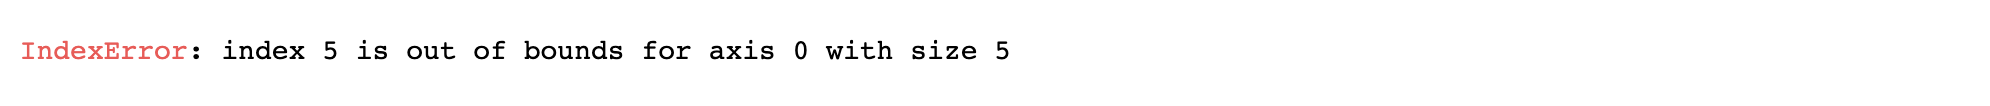

* 배치사이즈 2048 > 128 > 64 > 32 
* Data Cleansing 삭제
* 최근 1년 날짜로 하려고 했던 것 삭제
* 배치사이즈 다시 2048로 키움
  * 2048 > 1024 > 512 > 256

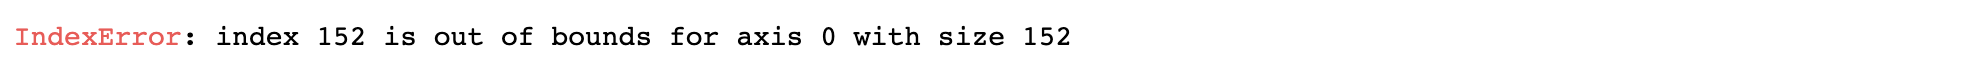

### 3-3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

* batch_size=**128**, hsz=50, drop_rate=0.1, lr=0.001, epochs=**3**, k=20
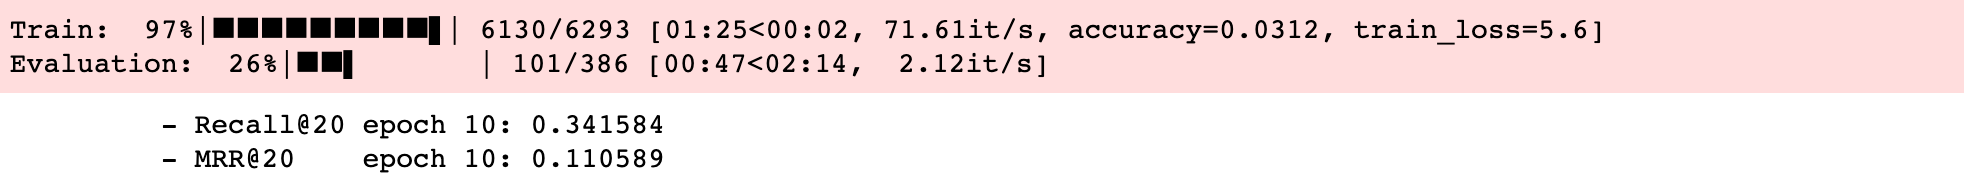

* batch_size=**64**, hsz=50, drop_rate=0.1, lr=0.001, epochs=**10**, k=20
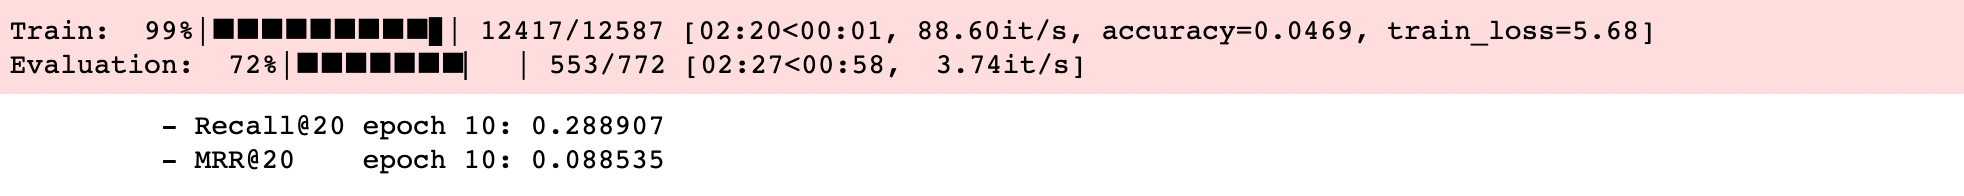

* batch_size=**32**, hsz=50, drop_rate=0.1, lr=0.001, epochs=**10**, k=20
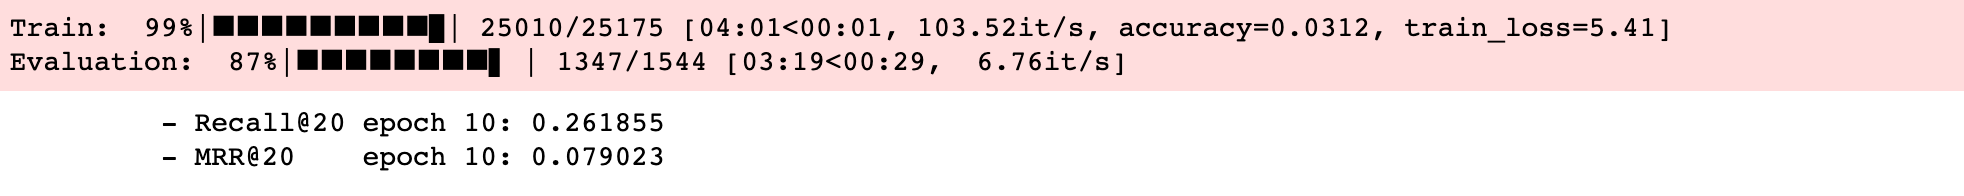

**Batch size와 Epoch 값을 다양하게 조절했을 때 Recall과 MRR 값의 의미있는 변화를 확인할 수 있다.**
* 에러 해결에 어려움을 겪던 중, 함께 스터디하는 진환님이 Batch Size 에 대한 팁을 주셨고, 그걸로 다양한 시도를 하며 에러를 해결할 수 있었다. 아직도 유의미한 Batch size를 직접 찾는데에는 어려움이 있다. 
<br/>
<br/>

### 3-4. 참고사이트
* 에러가 있어서 검색했지만 에러를 해결할만한 정보가 있는 사이트는 없었다. 
* 진환님이 도움을 많이 얻을 수 있었던 참고사이트(?)였다! 